# Programming Exercise 8: Anomaly Detection and Recommender Systems

In [3]:
# All required libraries and functions  are imported in this cell
from __future__ import division     # Enable floating point division 
from IPython.utils import io        # Suppress undesired print commands  
import os as os                     # Operating system funcitons for navigation pursposes
import numpy as np                  # Numerical Library for matrix operations
import numpy.random as npr
import matplotlib.pyplot as plt     # Plotting Library 
import scipy.optimize as spo
import scipy.io as sio
import scipy.misc as scm
import warnings as iw
import operator                     # Utility for sorting index of value in array

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Sharp plots  

data_dir="C:/GitHub/ML_Coursera/ex8/data/"

In [4]:
# Return the contents of the data file
def load_data(data_dir,f_name):                       
    os.chdir(data_dir)
    data=sio.loadmat(f_name)
    return data

## 1 Anomaly detection

In [5]:
# Lets load the dataset
data=sio.loadmat('ex8data1.mat')
data.keys()

['yval', '__header__', '__globals__', 'Xval', 'X', '__version__']

In [6]:
X=data['X']
Xval=data['Xval']
yval=data['yval']
print X.shape,Xval.shape,yval.shape

(307L, 2L) (307L, 2L) (307L, 1L)


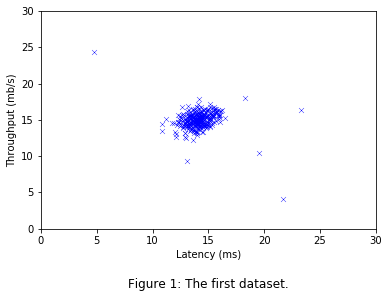

In [7]:
# Lets visualize the dataset
def plotData(X,text):
    plt.plot(X[:,0],X[:,1],'bx', ms=5, mew=0.4)
    plt.axis([0,30,0,30])
    plt.xlabel('Latency (ms)')
    plt.ylabel('Throughput (mb/s)')
    plt.title(text,y=-0.3)
    plt.show()

text='Figure 1: The first dataset.'
plotData(X,text)

In [8]:
## 1.1 Gaussian distribution

In [9]:
## 1.2 Estimating parameters for a Gaussian

In [13]:
def estimateGaussian(X):
    mu    = np.mean(X,axis=0)                    #columnwise mean
    sigma = np.std(X,axis=0)
    var   = (sigma)**2
    return mu,sigma

def p_func(x,mu,sigma):
    exponent = -(x-mu)**2/(2*sigma**2)
    norm_c   = 1/np.sqrt(2*np.pi*sigma**2)
    return norm_c*np.exp(exponent)

mu,sigma = estimateGaussian(X)

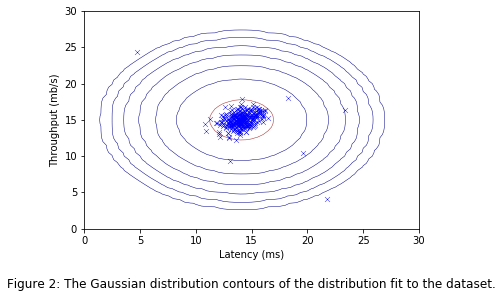

In [14]:
def plot_contour(X,text):
    # Generate a grid over x1 and x2
    x1=np.linspace(0,30,61)
    x2=np.linspace(0,30,61)
    u,v=np.meshgrid(x1,x2)

    # Estimate the combined probabilty function 
    P=np.multiply(p_func(u,mu[0],sigma[0]),p_func(v,mu[1],sigma[1]))
    cont_lvls=[10**exp for exp in range(-20,0,3)]
    clrs=['darkblue']*(len(cont_lvls)-1)+['brown']

    # Lets plot the model_contours and overlay data over it
    plt.contour(u,v,P,cont_lvls,colors=clrs,linewidths=0.5)
    plotData(X,text)
    plt.show()

text='Figure 2: The Gaussian distribution contours of the distribution fit to the dataset.'
plot_contour(X,text)

In [15]:
# 1.3 Selecting the threshold, epsilon

In [17]:
# Cross validation set Xval, yval
# Lets estimate probabilities for X on cv set


P_cv=np.multiply(p_func(Xval[:,0], mu[0], sigma[0]),p_func(Xval[:,1], mu[1], sigma[1]))

def selectThreshold(y,p_mat):
    epsilon_mat=np.arange(min(p_mat),max(p_mat),(max(p_mat)-min(p_mat))/1000)
    F1Score=[]
    m_val = y.shape[0]
    for i in epsilon_mat:
        tp, fp, fn = 0, 0, 0
        #yp=np.zeros(m_val)
        for j in range(m_val):
            if p_mat[j]<i:
                yp=1
                if yp==y[j]:tp+=1
                else:fp+=1  
            else: 
                yp=0
                if y[j]==1:fn+=1
        if tp+fp>0 and tp+fn>0: 
            prec = tp/(tp+fp)
            rec = tp/(tp+fn)
            F1 = 2*prec*rec/(prec+rec)
            F1Score.append([F1,i])
        else: F1Score.append([0,i])
    F1Score=sorted(F1Score, key=itemgetter(0), reverse=True)
    return F1Score[0][0],F1Score[0][1]
f1,epsilon=selectThreshold(yval,P_cv)

print 'The optimal value of epsilon for detecting anomalies is: ',epsilon        

The optimal value of epsilon for detecting anomalies is:  8.99085277927e-05


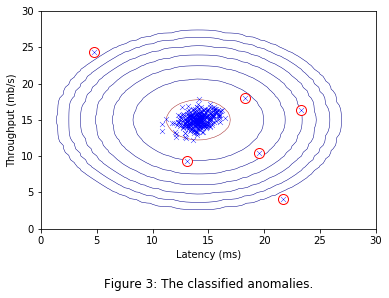

In [19]:
# Lets detect the anomaliesin the Training set based in epsilon=8.99e-05
text='Figure 3: The classified anomalies.'
X=data['X']
P_tr=np.multiply(p_func(X[:,0], mu[0], sigma[0]),p_func(X[:,1], mu[1], sigma[1]))
X_anomaly=[]
for i in range(X.shape[0]):
    if P_tr[i]<epsilon:X_anomaly.append(X[i])
X_anomaly=np.array(X_anomaly)
plt.plot(X_anomaly[:,0],X_anomaly[:,1], 'ro', mfc='w', ms=10)    
plot_contour(X,text)



In [20]:
## 1.4 High dimesinal dataset

In [21]:
data2=sio.loadmat('ex8data2.mat')
data2.keys()

['yval', '__header__', '__globals__', 'Xval', 'X', '__version__']

In [24]:
X_L=data2['X']
Xval_L=data2['Xval']
yval_L=data2['yval']

n_features=X_L.shape[1]
m_cv=Xval_L.shape[0]
m_L=X_L.shape[0]

P_cv_L=np.ones(m_cv)
P_L=np.ones(m_L)

mu_L,sigma_L=estimateGaussian(Xval_L)
for i in range(n_features):
    P_cv_L  =  np.multiply(P_cv_L,p_func(Xval_L[:,i],mu_L[i],sigma_L[i]))
    P_L     =  np.multiply(P_L,p_func(X_L[:,i],mu_L[i],sigma_L[i]))
    
f1_L,epsilon_L=selectThreshold(yval_L,P_cv_L)
ct=0
for i in range(m_L):
    if P_L[i]<epsilon_L: ct=ct+1
print 'Best F1 is ', f1_L, "\n", 'Best epislon is ',epsilon_L,"\n", \
'Number of anomalies detected in training data: ', ct

Best F1 is  0.615384615385 
Best epislon is  1.66205871119e-18 
Number of anomalies detected in training data:  125


In [ ]:
#I did not have time to find the mistake in the implementation, 
#f1-score close to the expected value. I will troubleshoot this later 

# 2 Recommender Systems

## 2.1 Movie ratings dataset

In [7]:
data=load_data(data_dir,'ex8_movies.mat')
data.keys()

['Y', 'R', '__version__', '__header__', '__globals__']

In [8]:
Y=data['Y']
R=data['R']
print Y.shape,R.shape

(1682L, 943L) (1682L, 943L)


In [10]:
'''
matrix Y: [num movies × num users matrix] stores the ratings y(i;j) (from 1 to 5).
matrix R: The matrix R is an binary-valued indicator matrix. where
       R(i; j) = 1 if user j gave a rating to movie i,
               = 0 otherwise.          
'''
# Note: Only use non-zero entries:np.nonzero returns the indices of nonzero elements 
print "Average movie rating for the first movie (Toy Story): ", \
round(np.mean(Y[0][np.nonzero(Y[0])]),1)    

Average movie rating for the first movie (Toy Story):  3.9


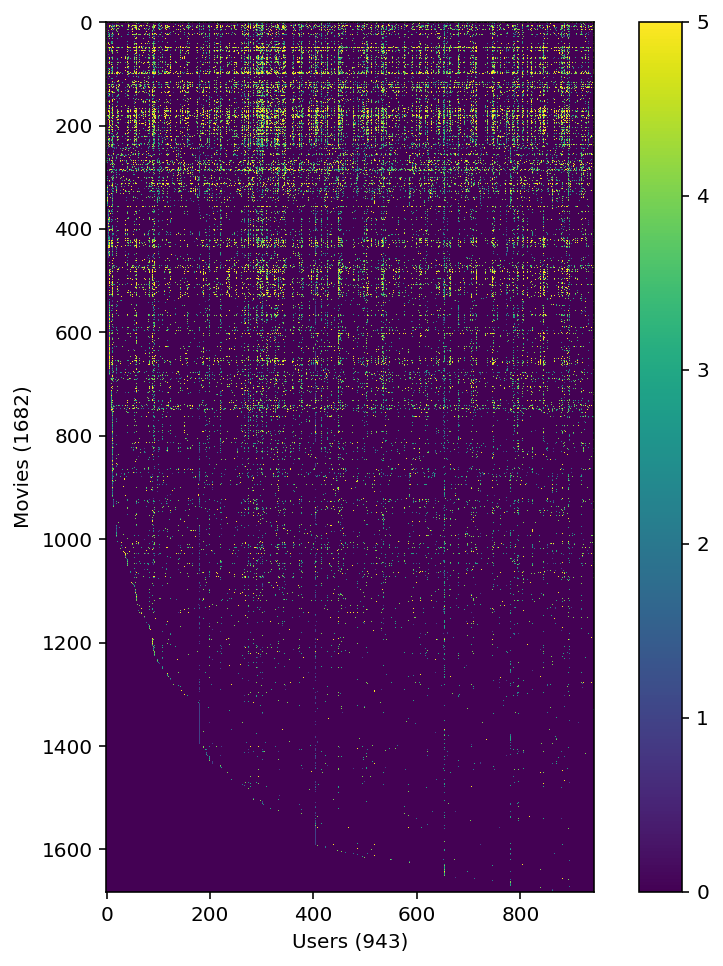

In [11]:
'''
Function:imagesc(C) 
imagesc(C) displays the data in array C as an image that uses the full range of colors 
in the colormap. Each element of C specifies the color for 1 pixel of the image. 
The resulting image is an m-by-n grid of pixels where m is the number of columns 
and n is the number of rows in C. The row and column indices of the elements determine 
the centers of the corresponding pixels.

Source: https://www.mathworks.com/help/matlab/ref/imagesc.html
'''
# Lets visualize the ratings matrix
plt.figure(figsize=(8,8))
plt.imshow(Y)
plt.colorbar()
plt.xlabel('Users (943)')
plt.ylabel('Movies (1682)')

In [12]:
## 2.2 Collaborative filtering learning algorithm

In [13]:
### 2.2.1, 2.2.3 Collaborative filtering cost function with Regularization

In [6]:
params=load_data(data_dir,'ex8_movieParams.mat')
params.keys()

['num_features',
 '__header__',
 '__globals__',
 'num_users',
 'X',
 'Theta',
 '__version__',
 'num_movies']

In [68]:
X, Theta = params['X'], params['Theta']
nu, nm = params['num_users'].flatten()[0], params['num_movies'].flatten()[0]
nf = params['num_features'].flatten()[0]
print X.shape, Theta.shape, nu, nm, nf

 (1682L, 10L) (943L, 10L) 943 1682 10


In [100]:
'''
Here we need to give the minimizing function the input in the expected form.
This is needed because we are not coding the minimizer (here fmin_cg)
So we flatten X,theta and return the in a single row matrix which is desired for
'''
def flatten_params(X,Theta):
    '''
    Input:  X.shape: nm * nf 
            Theta.shape: nu * nf'
    Output: (nm *nf + nu*nf,)
    '''
    return np.concatenate((X.flatten(), Theta.flatten()))

def reshape_params(flat_XTheta, nu, nm, nf):
    nu, nm, nf = int(nu), int(nm), int(nf)
    X=flat_XTheta[:nm*nf].reshape((nm,nf))
    Theta=flat_XTheta[nm*nf:].reshape((nu,nf)) 
    return X,Theta

def cofiCostFunc(flat_Xtheta, Y, R, nu, nm, nf,lambdA=0):
    nu, nm, nf = int(nu), int(nm), int(nf)
    X,Theta=reshape_params(flat_XTheta, nu, nm, nf)
    cost_term = (1/2)*np.sum( (np.multiply( np.matmul(X,Theta.T), R ) - Y)**2 )
    reg_Theta = (lambdA/2)*np.sum( np.matmul(Theta,Theta.T) )
    reg_X     = (lambdA/2)*np.sum( np.matmul(X.T,X) )
    return cost_term + reg_Theta + reg_X

flat_XTheta=flat_params(X,Theta)
J=cofiCostFunc(flat_XTheta,Y,R,nu, nm, nf,lambdA=0)
print J

27918.6401245


In [ ]:
### 2.2.2, 2.2.4 Collaborative filtering cost function with Regularization

In [106]:
def cofiGrad(flat_Xtheta, Y, R, nu, nm, nf,lambdA=0):
    nu, nm, nf = int(nu), int(nm), int(nf)
    X,Theta = reshape_params(flat_XTheta, nu, nm, nf)    
    grad_X  = np.matmul(  (np.multiply( np.matmul(X,Theta.T), R ) - Y) , Theta ) \
              + lambdA*X
    grad_Theta = np.matmul(  (np.multiply( np.matmul(X,Theta.T), R ) - Y).T, X ) \
                 +lambdA*Theta
    
    flat_XTheta_grad =  flat_params(grad_X,grad_Theta)
    return flat_XTheta_grad
    
Jp=cofiGrad(flat_XTheta,Y,R,nu, nm, nf,lambdA=0) 
print Jp

[-4.68881319  1.85901252 -5.08442411 ..., -4.63438191  3.72934198
  1.85226694]


In [107]:
# The vectorized equaiton worked, so I did not check. 
# I will revist this if I dont get expected results  & make code less dense

In [108]:
# 2.3 Learning movie recommendations